# Exercise 4: Advanced AD with Graph Neural Networks And Graph Auto Encoders

### Goals of the Exercise
- Make a Graph Autoencoder for event data, and use it for anomaly detection in events

### Graphs, and Graph Autoencoders

If you did the last exercise, and took a look at the grid based event data I provided, no doubt a great deal of it was just 0's. It's a lot of wasted space, math, and CPU/GPU time looking at those cells. And it doesn't really capture the _true_ structure of an event to have that whole grid there. Some events may have dozens of particles. Some 1 or 2. But we use the same grid each time. And the inconsistent and sparse nature of the input probably isnt doing our autoencoder any favors either.

To get around the shortcomings of this kind of input, and to get a real model of varying amounts of data, graphs are often used. The strict math definition of a graph is just some structure with both vertices and edges, but for our practical purposes, we will think of those vertices as also having features (and sometimes even edges will have features!), and when we say vertices mostly what we mean is particles (but it of course extends to other kinds of data that can be modeled by points with connections). Graphs have their own kind of neural networks called [Graph Neural Networks](https://en.wikipedia.org/wiki/Graph_neural_network). Graph neural networks are typically "message passing", that is a layer will accumulate information from it's neighbor vertices (up to a certain distance away), do standard neural network layer operations on this plus the node in question's information, and come up with a new feature for the next layer of the neural network/graph model. Graph neural networks can be used to make predictions per vertex, or even be entirely and become a standard flat neural network providing predictions about the graph as a whole.

Graph neural networks also have graph autoencoders. In fact, due to the complicated nature of graphs, there are conceptually a number of different kinds you can create and combine with traditional auto-encoder concepts. The most common kind is an edge-based auto encoder, that processes the node information into a flat vector per node, then simply tries to reconstruct the graph edges by inner products of the latent-space nodes, with binary-cross entropy being the loss for "edge" or "not edge" classifications. One could conceivably also, with enough information per node, ask the neural network to reconstruct the original node features, and ignore the graph edges.

For our exercise we are changing it up a bit and going to be using [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), an extension of the popular [Torch](https://pytorch.org/) neural network library. There does exist a graph neural network library for Tensorflow/Keras (Keras v2) called [Spektral](https://graphneural.network/) but in all honesty I have never used it, and it doesn't seem as complete, or as updated as PyTorch Geometric.

In [1]:
from rich.console import Console
console=Console()

In [2]:
import torch
from torch_geometric.loader import DataLoader
import numpy as np

zerobias_tensors = torch.load('data/graph_files/ZeroBiasGraphData.pt', weights_only=False)
jetht_tensors = torch.load('data/graph_files/JetHTGraphData.pt', weights_only=False)

np.random.shuffle(zerobias_tensors)

zerobias_train_tensors = zerobias_tensors[:round(0.6*len(zerobias_tensors))]
zerobias_val_tensors = zerobias_tensors[round(0.6*len(zerobias_tensors)):round(0.8*len(zerobias_tensors))]
zerobias_test_tensors = zerobias_tensors[round(0.8*len(zerobias_tensors)):]

#zerobias_load = DataLoader(zerobias_tensors, batch_size=32, shuffle=True)

zerobias_train_loader = DataLoader(zerobias_train_tensors, batch_size=32, shuffle=True)
zerobias_val_loader = DataLoader(zerobias_val_tensors, batch_size=32, shuffle=True)
zerobias_test_loader = DataLoader(zerobias_test_tensors, batch_size=32, shuffle=True)
jetht_load = DataLoader(jetht_tensors, batch_size=32, shuffle=True)

/afs/hep.wisc.edu/cms/aloeliger/anomalyTriggerWork/ADWorkshop/CMS_OpenData_Exercises/cms_opendata_exercises_env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In these files, I have provided graph tensors (a combination of nodes of features listed out as vectors, and an adjacency matrix listing the connections) of the 40 highest $p_{T}$ Particle Flow (PF) Candidates from a set of CMS events. Particle Flow Candidates are the base level of reconstruction at CMS, even before the more common reco objects like jets (PF hadrons are later clustered into jets or taus). The graph has been constructed as a k-nearest neighbors graph (with k = 3) in $\phi$ and $\eta$. There are 5 features provided by node, in order they are:

0. $p_{T}$
1. $\eta$
2. $\phi$
3. $m$
4. PDG ID

There are typically _far_ more PF Candidates per event than 40 (I counted Zero bias at on average having $\approx 900$, and Jet/HT at $\approx 1600$), but because these tensors can get _very_ large and the files containing them as well, I have had to restrict it to those with the most energy in the event, and relatively few features. Partially for this same reason, and partially because they are the only files with PF Candidates, I have also only provided ZeroBias and Jet HT datasets.

### Making a Graph Autoencoder

Making this autoencoder is a bit different from a keras model. [Pytorch geometric provides an inner-product decoder model/oberarching auto-encoder model](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAE.html#torch_geometric.nn.models.GAE), we simply need to provide the encoder ourselves. [The encoder is written up as a `torch.nn.Module`, which provides the `forward` function that defines what a forward pass of the neural network looks like](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html). The simplest message passing layers to use are [`GCNConv` layers](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv), but graph neural networks have [_many_ possible kinds of layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) compared to relatively fewer for standard neural networks, and they invent new ones all the time for various applications. We will start with `GCNConv` for now, but if you have the time, play around with others

Some things you can play around with here:

- The latent space for a graph auto-encoder is a bit funny. Because you are doing inner-products and determining the probability an edge exists, the latent space merely needs to be smaller than the smallest possible way of denoting every possible connection. which is potentially quite large. But this means it possibly helps for the features per node to _expand_ instead of contract, like you may be used to with a regular auto-encoder
- If you're really feeling quite adventurous, and familiar with pytorch and pytorch geometric, something I've always wanted to try is a _node-wise_ auto-encoder. Instead of attempting to reconstruct edge connections, instead make a more typical graph neural network that compresses each node into a latent space, then attempts to decompress it. I have literally never tried this (but always wanted to to test its capabilities), so it might be interesting to check how this functions. You have relatively limited features per node to work with, but, it may be worth a shot to see how it functions with a basic MSE loss per node compared to binary cross entropy per edge.

In [3]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.nn.models import GAE

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'

In [4]:
#
# Exercise: Make a Graph Autoencoder model. Don't worry about training it yet
#

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.bn1 = BatchNorm(in_features)
        self.conv1 = GCNConv(in_features, 32)
        self.bn2=BatchNorm(32)
        self.conv2 = GCNConv(32, out_features)
    def forward(self, x, edge_index):
        x=x.to(torch.float)
        edge_index = edge_index.to(torch.int)

        x = self.bn1(x)
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn2(x)
        return self.conv2(x, edge_index)

encoder = GCNEncoder(in_features=5, out_features=8)
model = GAE(encoder)

In [5]:
#
# Exercise: write the training loop
#

from rich.progress import track
import torch.optim as optim
from torch_geometric.utils import remove_self_loops, negative_sampling

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Because pytorch is a little more hands off, our training loop needs to be handcrafted
def train():
    model.train()
    total_loss = 0.0
    for data in track(zerobias_train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        #Actual do the encode and decode step in the neural network
        z = model.forward(x=data.x, edge_index=data.edge_index)

        #Get the edge indices so that we can compute the loss on the decoded graph
        #print(data)
        pos_edge_index, _ = remove_self_loops(data.edge_index)
        pos_edge_index = pos_edge_index.to(torch.int)
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        ).to(torch.int)
        #Get the loss from the model's recon_loss() function
        loss = model.recon_loss(z, pos_edge_index, neg_edge_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(zerobias_train_loader)

# we use a similar loop for validation measurements
def train_loop_validation():
    model.eval()
    total_loss = 0.0
    for data in zerobias_val_loader:
        #Actual do the encode and decode step in the neural network
        z = model.forward(x=data.x, edge_index=data.edge_index)

        #Get the edge indices so that we can compute the loss on the decoded graph
        pos_edge_index, _ = remove_self_loops(data.edge_index)
        pos_edge_index = pos_edge_index.to(torch.int)
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        ).to(torch.int)
        #Get the loss from the model's recon_loss() function
        loss = model.recon_loss(z, pos_edge_index, neg_edge_index)

        total_loss += loss.item()
    return total_loss / len(zerobias_val_loader)

for epoch in range(1,11):
    loss = train()
    console.print(f'Epoch {epoch}, loss: {loss}')
    val_loss = train_loop_validation()
    console.print(f'Epoch {epoch}, validation loss: {val_loss}')
    console.print()

Output()

Epoch 1, loss: 0.9638027763863405

Epoch 1, validation loss: 0.9068939128518104

Output()

Epoch 2, loss: 0.8901073899368445

Epoch 2, validation loss: 0.8926169709861278

Output()

Epoch 3, loss: 0.8839958270887533

Epoch 3, validation loss: 0.8872955007851124

Output()

Epoch 4, loss: 0.8817962613205115

Epoch 4, validation loss: 0.886822081208229

Output()

Epoch 5, loss: 0.8804998221993446

Epoch 5, validation loss: 0.8862362295389176

Output()

Epoch 6, loss: 0.880144536793232

Epoch 6, validation loss: 0.8836936615407467

Output()

Epoch 7, loss: 0.8791168921689192

Epoch 7, validation loss: 0.884387728124857

Output()

Epoch 8, loss: 0.8788703789313634

Epoch 8, validation loss: 0.8840340583026409

Output()

Epoch 9, loss: 0.8788475400209427

Epoch 9, validation loss: 0.8838393945991992

Output()

Epoch 10, loss: 0.8787633652985096

Epoch 10, validation loss: 0.8853685864806176

Okay. We have a model. Now we need to use it and figure out some anomaly scores. I will provide a function for running on the jetht_dataloader, you provide the ROC curves

In [20]:
def compute_loss_per_graph(model, data_loader, device):
    model.eval()
    losses=[]
    
    for data in data_loader:
        data.to(device)
        z=model.forward(x=data.x, edge_index=data.edge_index)

        #Split the batch into distinct graphs
        batch_size=data.num_graphs
        edge_index=data.edge_index
        node_splits = torch.unique(data.batch, return_counts=True)[1].cumsum(0)
        node_splits = torch.cat([torch.tensor([0], device=device), node_splits])

        for i in range(batch_size):
            # Mask to get nodes/edges for graph i
            node_start, node_end = node_splits[i], node_splits[i+1]
            node_mask = (data.batch == i)
            node_indices = torch.arange(node_start, node_end, device=device)

            # Filter edges belonging to this graph
            src, dst = edge_index
            edge_mask = node_mask[src] & node_mask[dst]
            pos_edge_index = edge_index[:, edge_mask]

            if pos_edge_index.size(1) == 0:
                losses.append(torch.tensor(float('nan'), device=device))
                continue

            # Negative sampling for this graph
            neg_edge_index = negative_sampling(
                edge_index=pos_edge_index,
                num_nodes=node_mask.sum().item(),
                num_neg_samples=pos_edge_index.size(1)
            )

            # Reconstruct with masked z
            z_i = z[node_mask]

            # Compute loss for this graph
            loss = model.recon_loss(z_i, pos_edge_index - node_start, neg_edge_index)

            #loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
            losses.append(loss.item())

    return losses  # List of float losses (1 per graph)

In [21]:
#
# Exercise: Use the above function to make some losses on our test sets, and look at how well our graph autoencoder does for anomaly detection
#

zerobias_losses = compute_loss_per_graph(model, zerobias_test_loader, 'cpu')
jetht_losses = compute_loss_per_graph(model, jetht_load, 'cpu')

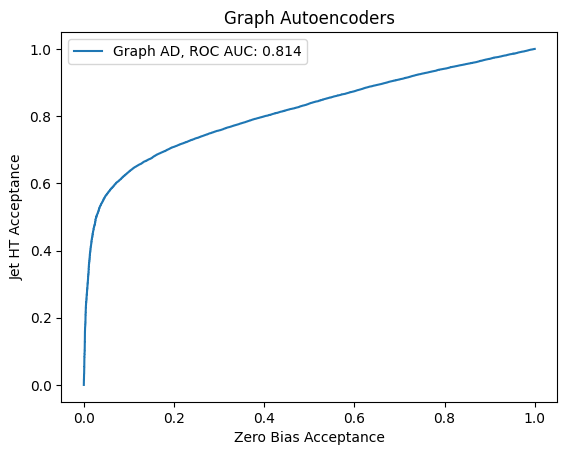

<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_true = np.append(
    np.ones(len(jetht_losses)),
    np.zeros(len(zerobias_losses)),
)

y_pred = np.append(
    np.array(jetht_losses),
    np.array(zerobias_losses),
)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(
    fpr,
    tpr,
    label=f'Graph AD, ROC AUC: {auc:.04g}',
)
plt.xlabel('Zero Bias Acceptance')
plt.ylabel('Jet HT Acceptance')
plt.title("Graph Autoencoders")
plt.legend()
plt.show()
plt.clf()

Hmmm. If your thing is anything like mine the AUC will be _okay_ but not really _inspiring_ ($\approx 0.814$) compared to some things we've seen. Don't let this sour you on the idea of graphs for anomaly detection. There were a lot of sacrifices that had to be made to get this to work at all (few PFCands, few features, few examples). In addition, the graph I made for you was quite basic, inspired by nothing other than physical distance in the detector coordinates most frequently used, and it really wasn't all that interconnected either, with each PF Candidate only connected to 3 other particles. It could even be that our graph autoencoder is _too good at physics_ and we are experiencing significant out of set reconstruction.

In fact, with as few PF cands (possibly less than could be contained in a jet!) that we've used, it is kind of good that it works this well at this point.

There are any number of things that could be tweaked with this approach to get it to perform a bit better. We could change the graphs we use to be more expressive. More features per node would be good too, as would more examples to train (the space requirements for these graphs can grow fast). We could try more complicated models or layers. The combinations may not be endless, but graph autoencoders come with a ton of expressive power, and consequently a huge number of things that could be tuned. Keep giving it a try.

### Wrap Up

Congratulations! This is just about everything I could think up for fluency in anomaly detection on physics data. It is not every topic out there, it is an active field of research after all, but if you were unfamiliar with anomaly detection before hopefully this can get you started, and if you were working with anomaly detection already, hopefully this has given you a few ideas.